# Test code of auto-focusing method for synthetic data

## Read the array geometry of Hi-net

In [1]:
import obspy.geodetics.base as geod
import numpy.random as random
import numpy as np
import sys
from scipy import signal
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import pickle

model = TauPyModel(model="ak135")
[lats,lons]=pickle.load(open("stations.pickle","rb"))

In [2]:
stnum = len(lons)
dx = np.zeros(stnum)
dy = np.zeros(stnum)
TT = np.zeros(stnum)
d   = np.zeros(stnum, dtype=np.complex)
w = np.zeros(stnum)
st_arc = np.zeros(stnum)
st_az    = np.zeros(stnum)
ev_arc = np.zeros(stnum)

freq = 0.15
ω = freq*2*np.pi

evlon = 170 
evlat = 70  

for i in range(len(lons)):
    [dist,st_az[i],baz] = geod.gps2dist_azimuth(lats.mean(),lons.mean(),lats[i],lons[i])
    st_arc[i] = geod.kilometer2degrees(dist*1E-3)
    dx[i] = np.sin(st_az[i]*np.pi/180.)*dist*1E-3
    dy[i] = np.cos(st_az[i]*np.pi/180.)*dist*1E-3 
    ev_arc[i] = geod.kilometer2degrees(geod.gps2dist_azimuth(evlat,evlon,lats[i],lons[i])[0]*1E-3)
    arrivals = model.get_travel_times(source_depth_in_km=0,distance_in_degree=ev_arc[i],phase_list=["P"])
    TT[i] = arrivals[0].time 
    d[i] = complex(np.cos(-ω*TT[i]),np.sin(-ω*TT[i])) #+ 2*random.randn()
    w[i] = 1 
gcarc = geod.kilometer2degrees(geod.gps2dist_azimuth(evlat,evlon,lats.mean(),lons.mean())[0]*1E-3)

arrivals2 = model.get_travel_times(source_depth_in_km=0,distance_in_degree=gcarc+0.1,phase_list=["P"])
arrivals1 = model.get_travel_times(source_depth_in_km=0,distance_in_degree=gcarc,phase_list=["P"])

p_ray = arrivals1[0].ray_param*np.pi/180
dpdl_ray= (arrivals2[0].ray_param-arrivals1[0].ray_param)/6371/(6371*np.pi/1800)
print(gcarc,p_ray,dpdl_ray)

37.46672760382978 8.47575114693 -5.17247658529e-06


# Beamforming for the initial guess

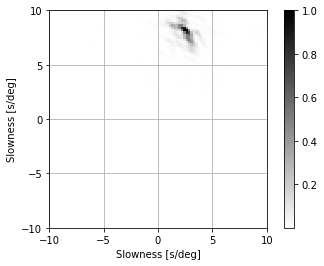

In [3]:
pmax = 0.1
dp = 2.E-3
n  =  int(pmax/dp+.5)
out = np.zeros([2*n+1,2*n+1])

for ipx in range(0,2*n+1):
    px = (ipx-n)*dp
    for ipy in range(0,2*n+1):
        py = (ipy-n)*dp
        sum = complex(0.,0.)
        for i in range(stnum):
            dtau = -px*dx[i]-py*dy[i]
            sum += d[i]*complex(np.cos(ω*dtau),np.sin(ω*dtau))*w[i]
        out[ipx][ipy]= np.real(sum*np.conj(sum))

idx = np.unravel_index(out.argmax(), out.shape)
[px0, py0] = [(idx[0]-n)*dp,(idx[1]-n)*dp]
[px_BF, py_BF] = [px0,py0]

#Plot 
deg2km = 6371*np.pi/180
plt.imshow(out.T/np.max(out),origin='lower',interpolation='none',extent=[-n*dp*deg2km,n*dp*deg2km,-n*dp*deg2km,n*dp*deg2km],cmap="gray_r")
plt.grid()
plt.colorbar()
plt.xlabel("Slowness [s/deg]")
plt.ylabel("Slowness [s/deg]")
plt.xticks(np.arange(-10,15,5))
plt.yticks(np.arange(-10,15,5))
plt.xlim(-10,10)
plt.ylim(-10,10)

plt.show()

In [4]:
from scipy import linalg
from scipy.optimize import minimize
import sys

def cal_S(p,θ,Δ,dp_Δ):
    [ex,ey] = [np.cos(θ),np.sin(θ)]
    x=[]
    y=[]
    dτ = np.zeros(4)
    ddτ = np.zeros([len(dτ),len(dτ)])
    φ = complex(0,0)
    dφ = np.zeros(len(dτ),dtype=complex)
    ddφ = np.zeros([len(dτ),len(dτ)],dtype=complex)


    for i in range(stnum):
        η = ( ex*dx[i]+ey*dy[i])/6371.
        ζ = (-ey*dx[i]+ex*dy[i])/6371.
        tanΔ = np.tan(Δ)
        l = (-η+ζ**2/(2.*tanΔ)+η*ζ**2*(1./6.+ 1./(2.*tanΔ**2))) *6371.
        τ =  l*(p+dp_Δ*l/2)

        Amp = d[i]*complex(np.cos(ω*τ),np.sin(ω*τ))
        φ += Amp*w[i] 
    S = np.real(φ*np.conj(φ))
    return S
def cal_mat(p,θ,Δ,dp_Δ):
    [ex,ey] = [np.cos(θ),np.sin(θ)]
    x=[]; y=[]
    dτ = np.zeros(4)
    ddτ = np.zeros([len(dτ),len(dτ)])
    φ = complex(0,0)
    dφ = np.zeros(len(dτ),dtype=complex)
    ddφ = np.zeros([len(dτ),len(dτ)],dtype=complex)


    for i in range(stnum):
        η = ( ex*dx[i]+ey*dy[i])/6371.
        ζ = (-ey*dx[i]+ex*dy[i])/6371.
        tanΔ = np.tan(Δ)
        sinΔ = np.sin(Δ)
        cotΔ = 1./tanΔ
        
        l = (-η+ζ**2/(2.*tanΔ)+η*ζ**2*(1./6.+ cotΔ**2/2.)) *6371.
        dl_θ = (-ζ*(1+η*cotΔ)+(1/6. + cotΔ**2/2.)*ζ*(ζ**2-2*η**2))*6371.
        dl_Δ  = (-(ζ/sinΔ)**2/2-η*ζ**2*cotΔ/(sinΔ**2))*6371.
        ddl_θ2 = (η+(η**2-ζ**2)*cotΔ +1/6.*(1+3*cotΔ**2)*(2*η**3-7*η*ζ**2))*6371.
        ddl_θΔ = (ζ*η/(sinΔ**2)+ζ/(sinΔ**2)*cotΔ*(2*η**2-ζ**2))*6371.
        ddl_Δ2 = (ζ**2/(sinΔ**2)*(cotΔ+η*(3/(sinΔ**2)-2)))*6371.
        τ =  l*(p+dp_Δ*l/2)
        #0: p, 1: ϕ, 2: Δ
        dτ[0] = l
        dτ[1] = p*dl_θ + dp_Δ*l*dl_θ 
        dτ[2] = p*dl_Δ + dp_Δ*l*dl_Δ
        dτ[3] = l**2/2 
        
        ddτ[0][0] = 0.
        ddτ[0][1] = dl_θ
        ddτ[0][2] = dl_Δ
        ddτ[0][3] = 0.

        ddτ[1][0] = ddτ[0][1]
        ddτ[1][1] = p*ddl_θ2+dp_Δ*(dl_θ**2+l*ddl_θ2)
        ddτ[1][2] = p*ddl_θΔ+dp_Δ*(dl_θ*dl_Δ+l*ddl_θΔ)
        ddτ[1][3] = l*dl_θ 
        
        ddτ[2][0] = ddτ[0][2]
        ddτ[2][1] = ddτ[1][2]
        ddτ[2][2] = p*ddl_Δ2 + dp_Δ*(dl_Δ**2+l*ddl_Δ2)
        ddτ[2][3] = l*dl_Δ 
        
        ddτ[3][0] = ddτ[0][3]
        ddτ[3][1] = ddτ[1][3]
        ddτ[3][2] = ddτ[2][3]
        ddτ[3][3] = 0

        Amp = d[i]*complex(np.cos(ω*τ),np.sin(ω*τ))
        φ += Amp*w[i] 
        for k in range(len(dτ)): dφ[k] += 1.j*ω*Amp*dτ[k]*w[i]
        for k in range(len(dτ)):
            for l in range(len(dτ)):
                ddϕ[k][l] += (-ω**2*Amp*dτ[k]*dτ[l]+1j*ω*Amp*ddτ[k][l])*w[i]
        
    S = np.real(φ*np.conj(φ))
    dS = np.array([2*np.real(np.conj(φ)*dφ[k]) for k in range(len(dτ))])
    ddS = np.zeros([len(dτ),len(dτ)])
    for k in range(len(dτ)):
        for l in range(len(dτ)):
            ddS[k][l] = 2*np.real(np.conj(dφ[k])*dφ[l]+np.conj(φ)*ddφ[k][l])
    return S,dS,ddS


In [5]:
p0 = np.sqrt(px_BF**2+py_BF**2)
[ex0,ey0] = [px_BF,py_BF]/p0
θ0 = np.arctan2(ey0,ex0)
xt = np.arange(0,90,2)
yt = np.arange(-80*p0*2E-6,20*p0*2E-6,p0*2E-6)
Sall = np.zeros([len(xt),len(yt)])

X, Y = np.meshgrid(xt, yt)
for ideg in range(len(xt)):
    deg = xt[ideg]
    for idp_Δ in range(len(yt)):
        dp_Δ2 = yt[idp_Δ]
        Δ = np.radians(deg)
        S0 = cal_S(p0,θ0,Δ,dp_Δ2)
        Sall[ideg][idp_Δ]=(S0/out.max())

idx = np.argmax(Sall.T[np.where(abs(yt)<1E-10)[0][0],1:])+1
ptmp = xt[np.argmax(Sall.T[np.where(abs(yt)<1E-10)[0][0],1:])+1]
idx2 = np.argmax(Sall.T[:,idx])

/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in cos
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sin
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


# Measurements of the curvature of the wave front

In [7]:
p0 = np.sqrt(px_BF**2+py_BF**2)
[ex0,ey0] = [px0,py0]/p0
θ0 = np.arctan2(ey0,ex0) #　angle of polar coordinate

#Grid search for the curvature (fixed slowness to the initial guessed slowness)
#deg means radius of curvature in degree
x=[]; y=[]
for deg in np.arange(1,180,2):
    Δ0 = np.radians(deg)
    S0 = cal_S(p0,θ0,Δ0,0)
    x.append(deg); y.append(S0/out.max())
x = np.array(x); y = np.array(y)
print(x[y.argmax()])

Δ0 = x[y.argmax()]/180.*np.pi
dp_Δ = 0
dp_Δ = yt[idx2]

Winv = np.array([0.06,np.pi/2.,np.pi/2,.04/ (30.*111)])
#First order correction of the curvature and the slowness
y, p_plt, θ_plt, Δ_plt, dp_Δ_plt =[], [],[],[],[]
iΛ = np.zeros(4)

S0 = cal_S(p0,θ0,Δ0,dp_Δ)
S1 = S0/2
Sinit = S0
y.append(S0/out.max())
p_plt.append(p0)
θ_plt.append(θ0)
Δ_plt.append(Δ0)
dp_Δ_plt.append(dp_Δ)
for i in range(100):
    r = 1.
    [S0,dS0,ddS0] = cal_mat(p0,θ0,Δ0,dp_Δ)
    ddS2 = ddS0 * (Winv.reshape(1,-1).T @ Winv.reshape(1,-1))

    dS2  = dS0*Winv
    Λ, Q = linalg.eigh(ddS2)
    dS3 = Q.T @ dS2
    for ieig in range(4):
        if Λ[ieig] >0: iΛ[ieig] = -dS3[ieig]/Λ[ieig]/2.
        else: iΛ[ieig] = dS3[ieig]/Λ[ieig] 
    δprm = Winv * (Q@iΛ)
    for loop in range(10):
        p1 = p0 - r* δprm[0]
        θ1 = θ0 - r* δprm[1]
        Δ1 = Δ0 - r* δprm[2]
        dp_Δ1 = dp_Δ - r* δprm[3]
        S1 = cal_S(p1,θ1,Δ1,dp_Δ1)
        dS = S1 -S0

        if dS >= 0:
            #print(i,r,S0/Sinit,p0,np.rad2deg(θ0),np.rad2deg(Δ0),dp_Δ,dS/S0)
            p0 =p1;  θ0 = θ1
            Δ0 = Δ1; dp_Δ = dp_Δ1
            S0 = S1
            break
        else:
            r = r * 0.8
    else: break
    y.append(S0/out.max())
    p_plt.append(p0)
    θ_plt.append(θ0)
    Δ_plt.append(Δ0)
    dp_Δ_plt.append(dp_Δ)
    if (abs(dS/S0) < 1E-9): break
Winv2 = np.array([p0,θ0,Δ0*2E1,dp_Δ*2E1])
ddS2 = ddS0 * (Winv2.reshape(1,-1).T @ Winv2.reshape(1,-1))

51


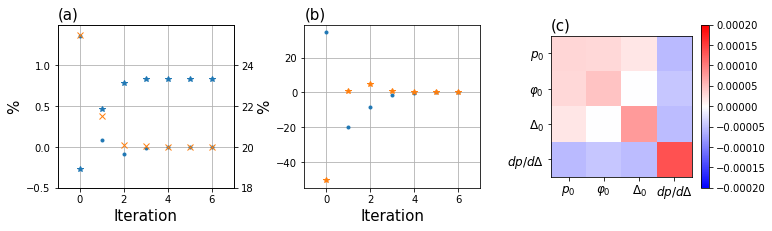

In [8]:
fig = plt.figure(figsize=(12, 3)) 
plt.subplots_adjust(wspace=0.4, hspace=0.3)
(ax1, ax2,ax3) = fig.subplots(1, 3)
ax1.plot(100*(p_plt/p0-1),".",label="$p/p_{true}$")
ax1.plot(100*(θ_plt/θ0-1),"x",label="$\phi/\phi_{true}$")
ax1.set_xlim(-1,7)
ax1.set_ylim(-0.5,1.5)
ax1.set_yticks(np.arange(-0.5,1.5,0.5))
ax1.grid()
ax1.set_title("(a)",fontsize=15,loc="left")
ax1.set_ylabel("%",fontsize=15)
ax1.set_xlabel("Iteration",fontsize=15)

ax2.plot(100*(Δ_plt/Δ0-1),".")
ax2.set_xlim(-1,7)
ax2.plot(100*(dp_Δ_plt/dp_Δ-1),"*")
ax2.grid()
ax2.set_title("(b)",fontsize=15,loc="left")
ax2.set_ylabel("%",fontsize=15)
ax2.set_xlabel("Iteration",fontsize=15)

cm = ax3.imshow(-np.linalg.inv(ddS2/(S0*1E-2)),cmap="bwr",vmin=-2E-4,vmax=2E-4)
plt.sca(ax3)
plt.xticks(range(4),["$p_0$",r"$\varphi_0$",r"$\Delta_0$",r"$dp/d\Delta$"],fontsize=12)
plt.yticks(range(4),["$p_0$",r"$\varphi_0$",r"$\Delta_0$",r"$dp/d\Delta$"],fontsize=12)
plt.colorbar(cm)
ax3.set_title("(c)",fontsize=15,loc="left")

ax0 = ax1.twinx()
ax0.set_ylim(18,26)
ax0.set_yticks(np.arange(18,26,2))
ax0.plot(100*(np.array(y)-1),"*",label="Beam power")
plt.show()

/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in cos
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sin
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/knishida/.pyenv/versions/anaconda3-5.3.1/envs/obspy/lib/pyth

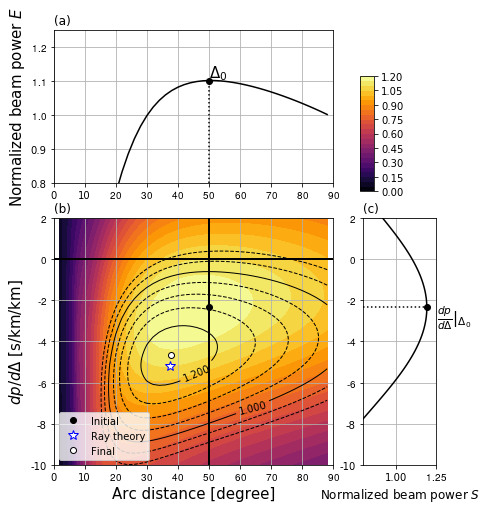

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Sall_mod = np.zeros([len(xt),len(yt)])
for ideg in range(len(xt)):
    deg = xt[ideg]
    for idp_Δ in range(len(yt)):
        dp_Δ2 = yt[idp_Δ]#(idp_Δ - 50)*p0*2E-6
        Δ = np.radians(deg)
        S0 = cal_S(p0,θ0,Δ,dp_Δ2)
        Sall_mod[ideg][idp_Δ]=(S0/out.max())

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

ax1 = plt.subplot2grid((5, 5), (2, 0), colspan=3,rowspan=3)
ax2 = plt.subplot2grid((5, 5), (0, 0), colspan=3,rowspan=2,sharex=ax1)
ax3 = plt.subplot2grid((5, 5), (2, 3), colspan=1,rowspan=3,sharey=ax1)

cm = ax1.contourf(X, Y*1E6, Sall.T,levels=np.arange(0.,1.25,0.05),cmap='inferno')
ax1.contour(X, Y*1E6, Sall_mod.T,levels=[0.9,.95,1.05,1.1,1.15,1.25,1.35], colors='k', linestyles='dashed', linewidths=1.0)
cntr = ax1.contour(X, Y*1E6, Sall_mod.T,levels=np.arange(1.,1.4,0.2), colors='k', linewidths=1.0)
ax1.clabel(cntr)

ax1.plot([ptmp,ptmp],[-10,2],color="k",linewidth=2)
ax1.plot([0,90],[0,0],color="k",linewidth=2)
ax1.plot(ptmp,yt[idx2]*1E6,"o",color="k",label="Initial")
ax1.set_ylabel(r"$dp/d\Delta~~\times10^{-6}$ [s/km/km]",fontsize=15)
ax1.set_ylim(-10,2)
ax1.set_xlim(0,90)
ax1.plot(gcarc,dpdl_ray*1E6,"*",color="blue", markerfacecolor='white',ms=10,label="Ray theory")
ax1.plot(np.rad2deg(Δ0),dp_Δ*1E6,"o",color="k", markerfacecolor='white',label="Final")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Arc distance [degree]", fontsize=15)
ax1.set_title("(b)",loc="left")

ax2.plot(xt,Sall.T[np.where(abs(yt)<1E-10)[0][0],:],color="k")
ax2.plot([50,50],[0.8,Sall.T[np.where(abs(yt)<1E-10)[0][0],idx]],color="k",ls=":")
ax2.plot(xt[idx],Sall.T[np.where(abs(yt)<1E-10)[0][0],idx],"o",color="k")
ax2.text(xt[idx],Sall.T[np.where(abs(yt)<1E-10)[0][0],idx]+.01,r"$\Delta_0$",fontsize=15)
ax2.grid()
ax2.set_ylim(0.8,1.25)
ax2.set_ylabel("Normalized beam power $E$",fontsize=15)
ax2.set_title("(a)",loc="left")

ax3.plot(Sall.T[:,idx],yt*1E6,color="k")
ax3.plot([0.8,Sall.T[idx2,idx]],[yt[idx2]*1E6,yt[idx2]*1E6],color="k",ls=":")
ax3.plot(Sall.T[idx2,idx],yt[idx2]*1E6,"o",color="k")
ax3.text(Sall.T[idx2,idx]+0.065,yt[idx2]*1E6-.8,r"$\left.\frac{dp}{d\Delta}\right|_{\Delta_0}$",color="k",fontsize=15)
ax3.grid()
ax3.set_xlim(0.8,1.25)
ax3.set_xlabel("Normalized beam power $S$",fontsize=12)
ax3.set_title("(c)",loc="left")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.55, 0.6, 0.02, 0.2])
plt.colorbar(cm,orientation='vertical',cax=cbar_ax)
plt.show()